Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
Segundo Semestre 2025<br>


<h1><center> Fundamentos de Machine Learning e Inteligencia Artificial Generativa:

**Trabajo final: Hate Speech Detection** </center></h1>
        **Profesor**: Miguel Fernández<br>
**Fecha de entrega**: 28/12/2025 23:59

---

# Integrantes
* Estudiante 1: Sara Benel Ramirez

# Librerías

In [1]:
!pip install -q transformers datasets huggingface_hub ipdb evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import html

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score

import torch
from torch import cuda
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import DatasetDict
from torch.nn import functional as F

import pathlib
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset, Value, ClassLabel, Features

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

# Introducción

El conjunto de datos utilizado en este estudio se construyó a partir de tweets obtenidos a través de la API de Twitter y filtrados utilizando un léxico de discurso de odio proporcionado por Hatebase.org. Inicialmente, se identificaron y recopilaron tweets que contenían términos específicos catalogados como discurso de odio por la comunidad. Este proceso resultó en una muestra de 85.4 millones de tweets, provenientes de 33,458 usuarios de Twitter.

Posteriormente, se realizó una selección aleatoria de tweets de esta muestra inicial para su análisis detallado. Estos tweets fueron evaluados manualmente por trabajadores de CrowdFlower (CF), quienes clasificaron cada tweet en una de tres categorías: discurso de odio, lenguaje ofensivo pero no discurso de odio, y ni ofensivo ni discurso de odio.

**Estructura del dataset**

Para el desarrollo de la tarea, se deben concentrar en dos columnas:

* tweet: Contiene la sentencia que debe ser evaluada.
* label: Clasificación asociada a cada sentencia de la variable tweet.

Respecto a la variable label, se tiene la siguiente codificación:

* 0 - discurso de odio
* 1 - lenguaje ofensivo
* 2 - ninguno

El conjunto de datos ya está divido en train (df_train) y test (df_test)

# 1 - Descripción del conjunto de datos (6 puntos)

Concatene ambos conjuntos de datos para tener una mirada general del dataset. Responda las siguiente preguntas:

* Grafique el número de ejemplos por tipo de clase. ¿El dataset está balanceado?
* Calcule el largo de las oraciones para cada clase, considerando el número de palabras. ¿Se observa algún patrón?
* Para cada clase, presente las 40 palabras más frecuentes. Comente.

Respuesta:

In [6]:
# A continuación, se presenta el código para cargar los conjuntos de train y test
# Se supone que los conjuntos df_train.csv y df_test.csv ya están subidos en el entorno de google colab

df_train = pd.read_csv('/content/df_train.csv')
df_test = pd.read_csv('/content/df_test.csv')

In [57]:
df_train

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet
0,21744,3,0,3,0,1,Talking Angela is a hoe
1,12933,3,0,2,1,1,Lol they tricking niccas left n right
2,997,3,0,3,0,1,&#128514;&#128514; bitches get stuff done. htt...
3,2534,3,0,3,0,1,@ArtaleGaspare bitch i got the flameeee
4,7470,3,0,3,0,1,@vivaalakatyy @brotherbill7 @JHuff_5 good bitc...
...,...,...,...,...,...,...,...
19821,17438,3,0,0,3,2,RT @RayIopez: When you're approaching your hig...
19822,7241,3,0,3,0,1,@skyereyes_ @keanabermudez YOOOOOOOOOOOOOO LMF...
19823,16347,3,0,0,3,2,RT @KelsieBelsi: @Vntxnius lmao it will have a...
19824,23517,3,1,2,0,1,"Y'all hoes broke, be stealing from the mall bu..."


In [56]:
df_test

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet
0,16183,3,0,3,0,1,RT @JimNorton: There is a GIFT SHOP at the 9-1...
1,3239,3,0,0,3,2,@Fabulousjonna_ I need some red green &amp; ye...
2,25097,3,0,3,0,1,this the one&#128076;RT @SumthinNueee hoes don...
3,365,3,0,3,0,1,"""@lildurk_: I can turn yo bitch into a eaterrr..."
4,16493,3,0,3,0,1,RT @LUNAraps: smh u got Ebola now RT&#8220;@Br...
...,...,...,...,...,...,...,...
4952,8198,3,0,2,1,1,Because of the message that sends to LGBTQ res...
4953,8435,3,0,3,0,1,Bruh this niggah always falls asleep ! &#12853...
4954,592,3,2,1,0,0,"""We're out here, and we're queer!""\n"" 2, 4, 6,..."
4955,18213,3,0,3,0,1,RT @TooTurntNacho: Why give a bitch ya heart w...


Identificamos que hay columnas que podemos eliminar ya que no seran necesarias. Esta eliminacion la haremos en la parte del preprocesamiento.
Ahora juntaremos los dos datasets SOLO para poder hacer un analisis de la totalidad.

In [58]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")
print(f"Combined size: {len(df_combined)}")
print(df_combined.head())

Train size: 19826
Test size: 4957
Combined size: 24783
   Unnamed: 0  count  hate_speech  offensive_language  neither  label  \
0       21744      3            0                   3        0      1   
1       12933      3            0                   2        1      1   
2         997      3            0                   3        0      1   
3        2534      3            0                   3        0      1   
4        7470      3            0                   3        0      1   

                                               tweet  
0                            Talking Angela is a hoe  
1              Lol they tricking niccas left n right  
2  &#128514;&#128514; bitches get stuff done. htt...  
3            @ArtaleGaspare bitch i got the flameeee  
4  @vivaalakatyy @brotherbill7 @JHuff_5 good bitc...  


In [ ]:
print(f"Total tweets: {len(df_combined)}")
print(f"\nLabel distribution:")
print(df_combined['label'].value_counts())

Total tweets: 24783

Label distribution:
label
1    19190
2     4163
0     1430
Name: count, dtype: int64


<Axes: xlabel='label'>

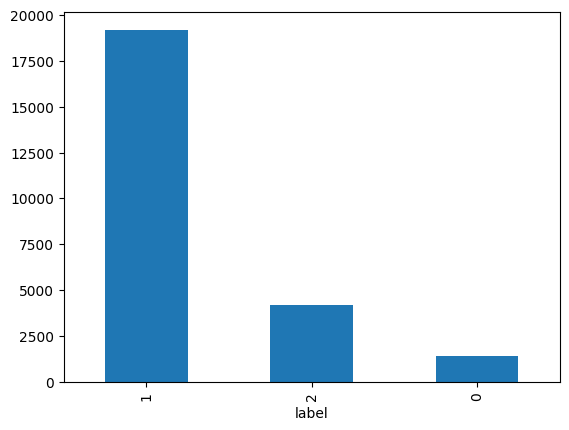

In [ ]:
df_combined['label'].value_counts().plot(kind='bar')

El dataset esta muy desbalanceado , puede ser que el modelo se sesgue y tienda a clasificar mas con el label 1 que con el 0.
Procederemos a calcular el largo de cada oracion y sacar un promedio de largo de oracion por clase para ver si hay un patron

In [ ]:
df_combined['word_count'] = df_combined['tweet'].str.split().str.len()

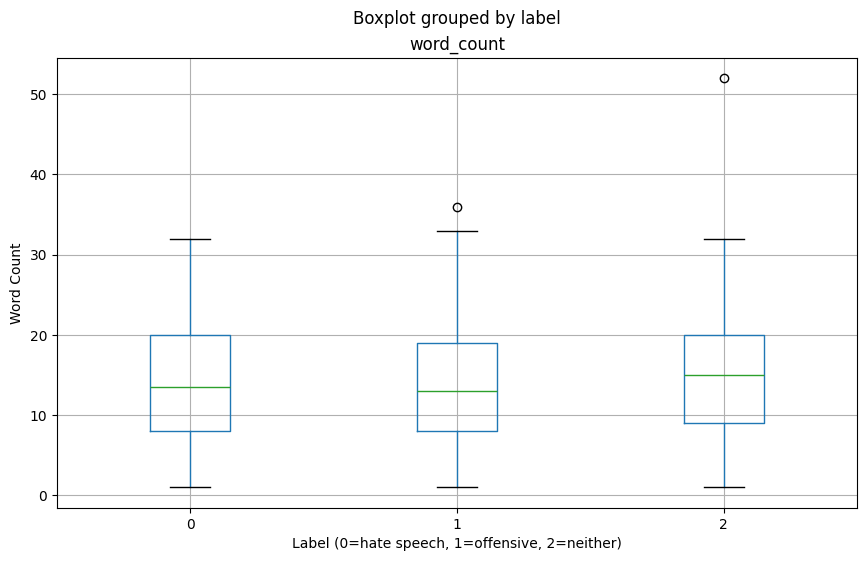

In [ ]:
df_combined.boxplot(column='word_count', by='label', figsize=(10, 6))
plt.xlabel('Label (0=hate speech, 1=offensive, 2=neither)')
plt.ylabel('Word Count')
plt.show()

In [ ]:
word_count_by_label = df_combined.groupby('label')['word_count'].describe()
print("Word count statistics by label:")
print(word_count_by_label)

Word count statistics by label:
         count       mean       std  min  25%   50%   75%   max
label                                                          
0       1430.0  13.906993  7.037868  1.0  8.0  13.5  20.0  32.0
1      19190.0  13.958624  6.802658  1.0  8.0  13.0  19.0  36.0
2       4163.0  14.919289  6.801590  1.0  9.0  15.0  20.0  52.0


Observaciones:
* Las distribuciones son bastante parecidas. Podemos observar que la mayoria de txtos se encuentran entre 8 y 20 palabras en todas las categorias.
* Otro indicadr es la media tambien, es muy parecida en las 3 categorias. Tal vez aqui resalta un poco la categoria 2 que tiene una media ligeramente mas elevada.
* Outliers: La catgoria 1 presenta un outlier de 36 palabras y la categoria 2 uno mucho mas elevado de 52 palabras.

Resumen:

* Uniformidad: Las distribuciones son uniformes, esto significa que la cantidad de palabras en un tweet no es indicador de pertenecer a alguna categoria.
* Pequeña variacion: La categoria 2 de 'neither' tiene una media un poco mas elevada y un outlier de fuera de lo comun, sin embargo la gran parte de su distribucion no va mas alla del rango de 32 (aprox) este dato inusual personalmente no creo que indique el texto neutro tiende a ser mas grande pero si podria indicar que los tweets de categoria neutra varian mas en su longitud.


Ahora procederemos a buscar las 40 palabras mas frecuentes.
Primero es muy probable que haya palabras en mayusculas y en minusculas, siendo las mismas palabras voy a uniformizar todo en minuscula.
Ademas voy a considerar que las stopwords estan muy presentes en cada clase, lo cual nos puede llevar a observar que las palabras mas comunes son las mismas en cada clase, considerare retirarlas SOLO para esta actividad, en el entrenamiento quiero que esten presentes.

In [ ]:
def get_words(text):
    # Convertir a minúsculas y extraer solo palabras
    text = text.lower()
    words = re.findall(r'\b[a-z]+\b', text)
    return words

In [ ]:
for label in sorted(df_combined['label'].unique()):
    tweets_label = df_combined[df_combined['label'] == label]['tweet']

    # Todas las palabras
    all_words = []
    for tweet in tweets_label:
        all_words.extend(get_words(str(tweet)))

    # Contar frecuencias
    word_freq = Counter(all_words)
    top_40 = word_freq.most_common(40)

    print(f"Total de palabras: {len(all_words)}")
    print(f"Palabras únicas: {len(word_freq)}")
    print(f"\nTop 40:")
    for i, (word, count) in enumerate(top_40, 1):
        print(f"{i:2}. {word:20} -> {count:5} veces")

Total de palabras: 19926
Palabras únicas: 4226

Top 40:
 1. a                    ->   550 veces
 2. you                  ->   505 veces
 3. i                    ->   442 veces
 4. the                  ->   388 veces
 5. rt                   ->   328 veces
 6. to                   ->   323 veces
 7. t                    ->   299 veces
 8. and                  ->   234 veces
 9. bitch                ->   209 veces
10. is                   ->   205 veces
11. that                 ->   196 veces
12. faggot               ->   191 veces
13. like                 ->   169 veces
14. in                   ->   163 veces
15. of                   ->   153 veces
16. my                   ->   145 veces
17. s                    ->   142 veces
18. nigga                ->   140 veces
19. ass                  ->   138 veces
20. be                   ->   131 veces
21. me                   ->   127 veces
22. white                ->   127 veces
23. all                  ->   126 veces
24. co                  

Claramente observamos que las stopwords se repiten en las clases. Ahora procedemos a retirarlas.

In [ ]:
stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'know',
                 'to', 'for', 'of', 'with', 'by', 'from', 'as', 'is', 'was','why','want','then','out','so','go',
                 'are', 'were', 'be', 'been', 'being', 'have', 'has', 'had','like','when','about','http',
                 'do', 'does', 'did', 'will', 'would', 'could', 'should','not','just','if','who','get','up','got','how',
                 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'my', 'all','can','your',
                 'this', 'that', 'these', 'those', 'am', 'me', 'rt'])

def get_words_no_stopwords(text):
    text = text.lower()
    words = re.findall(r'\b[a-z]+\b', text)
    # Filtrar stopwords
    return [w for w in words if w not in stopwords]

In [ ]:
for label in sorted(df_combined['label'].unique()):
    tweets_label = df_combined[df_combined['label'] == label]['tweet']

    all_words = []
    for tweet in tweets_label:
        all_words.extend(get_words_no_stopwords(str(tweet)))

    word_freq = Counter(all_words)
    top_40 = word_freq.most_common(40)
    print(f"\nLabel: {label}")
    print(f"Top 40:")
    for i, (word, count) in enumerate(top_40, 1):
        print(f"{i:2}. {word:20} -> {count:5} veces")


Label: 0
Top 40:
 1. t                    ->   299 veces
 2. bitch                ->   209 veces
 3. faggot               ->   191 veces
 4. s                    ->   142 veces
 5. nigga                ->   140 veces
 6. ass                  ->   138 veces
 7. white                ->   127 veces
 8. co                   ->   126 veces
 9. fuck                 ->   121 veces
10. trash                ->   113 veces
11. nigger               ->   112 veces
12. u                    ->   106 veces
13. fucking              ->    95 veces
14. re                   ->    77 veces
15. don                  ->    77 veces
16. niggas               ->    76 veces
17. fag                  ->    76 veces
18. what                 ->    75 veces
19. m                    ->    67 veces
20. faggots              ->    62 veces
21. no                   ->    61 veces
22. shit                 ->    60 veces
23. people               ->    59 veces
24. bitches              ->    59 veces
25. hate              

Podemos observar que aqui si vemos palabras mas representativas de sus clases.
* En la clase 0: hate speech observamos palabras como nigga,fuck, bitch, hoe, faggot, hate, stupid y sus variantes.
* En la clase 1:offensive tambien observamos palabras en comun con el label 0, como bitch, hoe, fuck, ass, pussy, nigga, pero tmb observamos palabras como love, good, girl
* En el label 2:neither observamos palabras neutras sustantivos como white, charlie, yellow, birds,good,love, people

# 2 - Preprocesamiento de texto (3 puntos)

Realice un preprocesamiento del texto. Justifique sus decisiones.

De implementar esta solución, siga trabajando con los conjuntos procesados para crear clasificadores basados en BOW y TF-IDF.

Respecto al entrenamiento del modelo transformer, evalúe si es conveniente aplicar el mismo preprocesamiento.

Respuesta:

Considero que no se debe realizar un preprocesamiento exahustivo, ya CountVectorizer puede manejar los stopwords.
Lo que si considero necesario es retirar las urls, html entities como &amp, que he visto que se repiten en most frequent words, espacios en blanco, y menciones de twitter que no servirian para esta clasificacion.

In [59]:
def clean_tweet(text: str) -> str:
    text = html.unescape(str(text)).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)   # URLs
    text = re.sub(r'@\w+', ' ', text)                    # mentions
    text = re.sub(r'#', ' ', text)                       # hash sign
    text = re.sub(r'&\w+;', ' ', text)                   # html entities
    text = re.sub(r"[^a-z\s'!]", ' ', text)              # text
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [60]:
df_train['clean_tweet'] = df_train['tweet'].apply(clean_tweet)
df_test['clean_tweet']  = df_test['tweet'].apply(clean_tweet)

In [61]:
df_train[['tweet','clean_tweet']][50:60]

,tweet,clean_tweet
50,John Kerry.... the SELLOUT: http://t.co/SFIRSv...,john kerry the sellout neverforget how this pu...
51,I lost all my respect for my brother cause you...,i lost all my respect for my brother cause you...
52,"""@EdgarPixar: Overdosing on heavy drugs doesn'...",overdosing on heavy drugs doesn't sound bad to...
53,@im_sarcasticc &#128527;&#128527;&#128527; Yas...,yas bitch don't have too much fun
54,"""Y'all forget he has his brand new baby girl a...",y'all forget he has his brand new baby girl at...
55,@_RichHomieKevin go to sleep niggah lol,go to sleep niggah lol
56,I would def call Dwight a cradle robbing faggo...,i would def call dwight a cradle robbing faggo...
57,RT @Bigboybeezy: &#8220;@IgnoreAllLaws: Pick o...,rt pick one the girl behind the bar who ain't ...
58,The baddest bitch is back on chestnut! @ryanco...,the baddest bitch is back on chestnut! welcome...
59,Pisses me of when I see these little liberal f...,pisses me of when i see these little liberal f...


He decidido borrar tambien emojis y puntuaciones como : , y "" pero mantener ' y signos de exclamacion

# 3 - Entrenar clasificador con BOW (6 puntos)

Construya la matriz Bag of Words (BOW) para los conjuntos train y test. Indique el tamaño del vocabulario considerando el set de train. Luego, entrene un clasificador utilizando una técnica de machine learning.

Calcule las métricas Precision, Recall y F1-score para el conjunto test (general y por clase). Comente los resultados.

Respuesta:

In [69]:
vectorizer = CountVectorizer(
    stop_words='english',
    #ngram_range=(1, 2),
    min_df=2,
)

In [71]:
x_train = vectorizer.fit_transform(df_train['clean_tweet'])
x_test = vectorizer.transform(df_test['clean_tweet'])

y_train = df_train['label']
y_test = df_test['label']

In [68]:
vocabulary_size = len(vectorizer.vocabulary_ )
print(f"Tamaño del vocabulario {vocabulary_size}")

Tamaño del vocabulario 17458


In [72]:
vocabulary_size = len(vectorizer.vocabulary_ )
print(f"Tamaño del vocabulario usando min_df: {vocabulary_size}")

Tamaño del vocabulario usando min_df: 7849


El tamaño del vocabulario solo retirando las stopwords es 17 458 .  Luego probé usando min_df que significa que la palabra tiene que aparecer al menos dos veces esto me dio 7 849. Voy a entrenar un clasificador usando 5k y 10k como vocabulary size y ver las métricas.

In [75]:
vocab_sizes = [5000, 10000]

for max_feat in vocab_sizes:
    print(f"Vocabulary size: {max_feat}")
    vec = CountVectorizer(max_features=max_feat, min_df=2,stop_words='english',)
    X_train_bow = vec.fit_transform(df_train['clean_tweet'])
    X_test_bow = vec.transform(df_test['clean_tweet'])

    print(f"Actual vocabulary size: {len(vec.vocabulary_)}")

    # Train
    clf = MultinomialNB()
    clf.fit(X_train_bow, df_train['label'])

    y_pred = clf.predict(X_test_bow)
    print(classification_report(df_test['label'], y_pred,
                                target_names=['hate speech', 'offensive', 'neither']))

Vocabulary size: 5000
Actual vocabulary size: 5000
              precision    recall  f1-score   support

 hate speech       0.44      0.20      0.27       286
   offensive       0.90      0.96      0.93      3838
     neither       0.85      0.76      0.81       833

    accuracy                           0.88      4957
   macro avg       0.73      0.64      0.67      4957
weighted avg       0.87      0.88      0.87      4957

Vocabulary size: 10000
Actual vocabulary size: 7849
              precision    recall  f1-score   support

 hate speech       0.35      0.12      0.18       286
   offensive       0.90      0.97      0.93      3838
     neither       0.86      0.74      0.80       833

    accuracy                           0.88      4957
   macro avg       0.70      0.61      0.64      4957
weighted avg       0.86      0.88      0.87      4957



Ahora sin min_df y vocabulary size de 20k

In [ ]:
max_feat = 20000
print(f"Vocabulary size: {max_feat}")
vec = CountVectorizer(max_features=max_feat,stop_words='english',)
X_train_bow = vec.fit_transform(df_train['clean_tweet'])
X_test_bow = vec.transform(df_test['clean_tweet'])

print(f"Actual vocabulary size: {len(vec.vocabulary_)}")

# Train
clf = MultinomialNB()
clf.fit(X_train_bow, df_train['label'])

y_pred = clf.predict(X_test_bow)
print(classification_report(df_test['label'], y_pred,
                            target_names=['hate speech', 'offensive', 'neither']))

Vocabulary size: 20000
Actual vocabulary size: 17458
              precision    recall  f1-score   support

 hate speech       0.41      0.05      0.09       286
   offensive       0.88      0.98      0.93      3838
     neither       0.88      0.65      0.75       833

    accuracy                           0.87      4957
   macro avg       0.72      0.56      0.59      4957
weighted avg       0.85      0.87      0.85      4957



Podemos ver que lo mejor es usar un vocabulary_size de 5k ya que nos de mejores métricas en accuracy, precision , recall por clase y f1-score que es una buena métrica para este caso de datasets desbalanceados.

Métricas:

* En cuanto a métricas lo podemos observar por ejemlo para hate speech con precision 0.44 que signfica que aprox + de la mitad de las predicciones son errores y un recall de 21 dando a entender que el modelo no detecta el 79% de los discursos de odio.
* También vemos que las mejores métricas son para la clase Offensive que es la dominante del dataset con una precision de 90% y recall de 96% dando como f1 0.93.

Resumen:

* Podemos observar que el modelo alcanza un 88% de accuracy, pero esta métrica es engañosa debido al desbalance de clases. El F1 ponderado (0.87) es alto porque el modelo predice muy bien la clase dominante "offensive", mientras que falla con las clases minoritarias.
* Esto es esperado en un dataset tan desbalanceado como lo observamos en la sección de descripción del dataset, es muy probable que clasifique como offensive un texto de hate speech.

#4 - Entrenar clasificador con TF-IDF (6 puntos)

Construya la matriz TF-IDF para los conjuntos train y test. Luego, entrene un clasificador mediante una técnica de machine learning.

Calcule las métricas Precision, Recall y F1-score para el conjunto test (general y por clase). Comente los resultados.


Respuesta:

In [95]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) #same vocabulary_size as bow

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['clean_tweet'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['clean_tweet'])

y_train = df_train['label']
y_test = df_test['label']

In [96]:
clf_tfidf = LogisticRegression(max_iter=1000, random_state=42) #we'll try with LogisticRegression and see how it goes
clf_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf,
                          target_names=['0:hate speech', '1:offensive', '2:neither']))

               precision    recall  f1-score   support

0:hate speech       0.61      0.16      0.25       286
  1:offensive       0.91      0.97      0.94      3838
    2:neither       0.85      0.82      0.83       833

     accuracy                           0.90      4957
    macro avg       0.79      0.65      0.67      4957
 weighted avg       0.88      0.90      0.88      4957



Aquí vemos un accuracy de 90% pero nuevamente esto es engañoso ya que si vemos las métricas a detalle tenemos mejores métricas en la clase offensive (con un recall de 97% y precision de 91%) pero en la clase hate speech vemos que el modelo no es capaz de precedir el 85% de textos de esa clase.

Si comparamos este approach TF-IDF + LogisticRegression vs BOW + MultinomialNB , podríamos decir que BOW + MultinomialNB dió un mejor resultado aunque de todas formas sigue siendo un modelo sesgado, el dataset aquí es fundamental para este comportamiento de los modelos.

# 5 - Entrenar clasificador con RoBERTa (9 puntos)

Utilizando el modelo RoBERTa-base, construya un clasificador para la tarea planteada.

Calcule las métricas Precision, Recall y F1-score para el conjunto test (general y por clase). Comente sus resultados.

Considere un entrenamiento por 3 épocas.



**Observación**

* Debe trabajar con GPU. El tiempo de entrenamiento es de 20 minutos, aproximadamente. **Se recomienda guardar el modelo para no repetir entrenamiento**.
* Respecto a la implementación desarrollada en clases, deben modificar la función ```compute_metrics```. A continuación, se presenta la función que debe ser utilizada:

```
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(references=labels, predictions=predictions, average='micro')
```  

Respuesta:

Se hará la implementación con las herramientas de hugging face y con el dataset en crudo

In [ ]:
train = Dataset.from_pandas(df_train[["tweet","label"]])
test = Dataset.from_pandas(df_test[["tweet","label"]])

In [ ]:
train

Dataset({
    features: ['tweet', 'label'],
    num_rows: 19826
})

In [ ]:
ds = DatasetDict()
ds

DatasetDict({
    
})

In [ ]:
ds["train"] = train
ds["test"] = test

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 19826
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 4957
    })
})

In [ ]:
ds["train"][0]

{'tweet': 'Talking Angela is a hoe', 'label': 1}

In [ ]:
from transformers import set_seed
set_seed(0) #Se establece una semilla para reproducir resultados

In [13]:
id2label = {0: 'hate speech', 1: 'offensive', 2: 'neither'} #'0:hate speech', '1:offensive', '2:neither'
label2id = {'hate speech': 0, 'offensive':1, 'neither':2}

In [ ]:
model_name = "roberta-base"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Voy a mantener 130 tokens como maximo ya que mi tweet mas largo tiene 52 palabras lo que calculando 1 palabra = 1.5 tokens serian 78 tokens y con un poco de espacio queda bien 130.

In [ ]:
tokenizer.model_max_length = 130

def tokenize(example):
    return tokenizer(example["tweet"], truncation="longest_first")

tokenized_ds = ds.map(tokenize)
tokenized_ds

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask'],
        num_rows: 19826
    })
    test: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4957
    })
})

In [ ]:
import evaluate
f1 = evaluate.load("f1") #probar con f1
accuracy_metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(references=labels, predictions=predictions, average='micro')

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

In [ ]:
train_args = TrainingArguments(
    report_to="none",
    output_dir='clf_hatespeech',
    eval_strategy="steps",
    save_strategy = "steps",
    learning_rate=2e-5,
    warmup_steps=250,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3, #3 de acuerdo al enunciado
    weight_decay=0.01,
    save_steps=100,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # de acuerdo con esta metrica ya que los datasets estan desbalanceados
    save_total_limit=2,

)

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,F1
100,No log,0.529955,0.793827
200,No log,0.281403,0.902966
300,No log,0.277390,0.911237
400,No log,0.245968,0.913456
500,0.418300,0.254408,0.914061
600,0.418300,0.237105,0.918701
700,0.418300,0.256191,0.913859
800,0.418300,0.258513,0.917289
900,0.418300,0.269835,0.916885
1000,0.244200,0.231246,0.915877


Step,Training Loss,Validation Loss,F1
100,No log,0.529955,0.793827
200,No log,0.281403,0.902966
300,No log,0.277390,0.911237
400,No log,0.245968,0.913456
500,0.418300,0.254408,0.914061
600,0.418300,0.237105,0.918701
700,0.418300,0.256191,0.913859
800,0.418300,0.258513,0.917289
900,0.418300,0.269835,0.916885
1000,0.244200,0.231246,0.915877


TrainOutput(global_step=1860, training_loss=0.271323739328692, metrics={'train_runtime': 1369.2991, 'train_samples_per_second': 43.437, 'train_steps_per_second': 1.358, 'total_flos': 2206115562411936.0, 'train_loss': 0.271323739328692, 'epoch': 3.0})

In [ ]:
trainer.save_model("clf_hatespeech/best_model")
tokenizer.save_pretrained("clf_hatespeech/best_model")

('clf_hatespeech/best_model/tokenizer_config.json',
 'clf_hatespeech/best_model/special_tokens_map.json',
 'clf_hatespeech/best_model/vocab.json',
 'clf_hatespeech/best_model/merges.txt',
 'clf_hatespeech/best_model/added_tokens.json',
 'clf_hatespeech/best_model/tokenizer.json')

In [ ]:
results = trainer.evaluate(tokenized_ds["test"])
results

{'eval_loss': 0.23710472881793976,
 'eval_f1': 0.9187008271131732,
 'eval_runtime': 18.9887,
 'eval_samples_per_second': 261.05,
 'eval_steps_per_second': 8.163,
 'epoch': 3.0}

Ahora vamos a cagar el modelo (desde donde lo guardamos o podemos obviar la carga si ya esta cargado despues del train) y ejecutar predict en el df de test

In [ ]:
model_name = "roberta-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_base = AutoModelForSequenceClassification.from_pretrained("clf_hatespeech/best_model",num_labels=3)
model_base.to(device)

tokenizer = AutoTokenizer.from_pretrained("clf_hatespeech/best_model")

In [ ]:
df_test = pd.DataFrame(ds["test"])
df_test

,tweet,label
0,RT @JimNorton: There is a GIFT SHOP at the 9-1...,1
1,@Fabulousjonna_ I need some red green &amp; ye...,2
2,this the one&#128076;RT @SumthinNueee hoes don...,1
3,"""@lildurk_: I can turn yo bitch into a eaterrr...",1
4,RT @LUNAraps: smh u got Ebola now RT&#8220;@Br...,1
...,...,...
4952,Because of the message that sends to LGBTQ res...,1
4953,Bruh this niggah always falls asleep ! &#12853...,1
4954,"""We're out here, and we're queer!""\n"" 2, 4, 6,...",0
4955,RT @TooTurntNacho: Why give a bitch ya heart w...,1


In [104]:
def predict(text):
    encoding = tokenizer.encode_plus(text, truncation="longest_first")

    inputs = {
        k:torch.LongTensor(encoding[k]).reshape(1, -1).to(device) for k in {"input_ids", "attention_mask"}#, "token_type_ids"}
    }

    with torch.no_grad():
      logits = model_base(**inputs).logits

    predicted_class_id = logits.argmax().item()
    return model_base.config.id2label[predicted_class_id]

In [ ]:
resultado = []
for i in tqdm(range(df_test.shape[0])): #df_test.shape[0]
  resultado.append(predict(df_test["tweet"][i]))

  0%|          | 0/4957 [00:00<?, ?it/s]

In [ ]:
df_test["predict"] = resultado
df_test["predict_cod"] = df_test.predict.apply(lambda x: label2id[x])
print(classification_report(df_test.label,df_test.predict_cod, target_names=['hate speech', 'offensive', 'neither']))

              precision    recall  f1-score   support

 hate speech       0.59      0.17      0.27       286
   offensive       0.93      0.97      0.95      3838
     neither       0.89      0.93      0.91       833

    accuracy                           0.92      4957
   macro avg       0.80      0.69      0.71      4957
weighted avg       0.91      0.92      0.90      4957



In [ ]:
df_test[['tweet', 'label', 'predict', 'predict_cod']][50:60]

,tweet,label,predict,predict_cod
50,I found your arm in that trash receptacle and ...,2,neither,2
51,I ain't really trippin about the money yo that...,1,offensive,1
52,@Misters206 You look like a monkey,2,neither,2
53,For instance...Nikki said BET you won't fight ...,1,offensive,1
54,RT @CuhCuhCuh: bitches name they make up off o...,1,offensive,1
55,I forgot how white trash Texarkana was... Well...,0,hate speech,0
56,@RniSwirvinn @LilKev_J no ur wrong stupid nigger,0,hate speech,0
57,@RunuldoRants faggot sack,0,offensive,1
58,RT @ogkels_: brought to you by bad bitches and...,1,offensive,1
59,RT @TEL1967: Darn trash man he beat me to the ...,2,neither,2


Podemos observar que con roberta los resultados son MUCHO mejores que usando las tecnicas anteriores y hay que tener en cuenta que no hemos realizado un preprocesamiento del texto y tampoco hemos aplicado tecnicas de balanceo del dataset.
La clase hate speech ha mejorado en metricas como accuracy superando el 50% , sim embargo vemos que el recall bajo un poco a comparacion de usar bow+multinb.
En total el modelo tiene un accuracy de 92% lo cual tambien es superior a los resultados anteriormente mostrados.

# 6 - Llama zero-shot (6 puntos)

Seleccione una muestra aleatoria de 10 ejemplos por categoría desde el conjunto de test (en total son 30 ejemplos). **Este conjunto creado debe ser utilizado en las siguientes preguntas**.

Utilice el modelo ```meta-llama/Llama-3.2-3B-Instruct``` para obtener predicciones para cada comentario. Justifique el diseño del prompt.

Ver modelo en: https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct

Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.

**Observación**

* Para utilizar este modelo debe registrarse en huggingface y solicitar permiso. Al importarlo, debe ingresar el token de huggingface. Revise la clase respectiva.
* Para esta pregunta deben trabajar con GPU.


Respuesta:

La siguiente celda de código permite ingresar el token para trabajar con el modelo.

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
sample_test = pd.DataFrame()
for label_id in [0, 1, 2]:
    class_samples = df_test[df_test['label'] == label_id].sample(n=10, random_state=42)
    sample_test = pd.concat([sample_test, class_samples])

sample_test = sample_test.reset_index(drop=True)
print(f"Mini dataset size: {len(sample_test)}")
print(f"Clases: {sample_test['label'].value_counts().sort_index()}")

Mini dataset size: 30
Clases: label
0    10
1    10
2    10
Name: count, dtype: int64


In [11]:
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline( #Se trabaja con pipeline para facilitar el uso del LLM
    "text-generation",
    model=model_id,
    dtype=torch.bfloat16,
    device_map=device,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda


In [ ]:
def create_prompt(tweet):
    messages = [
        {
            "role": "system",
            "content": "You are a hate speech detection expertin tweets. You must classify tweets into exactly one of three categories: 'hate speech', 'offensive', or 'neither'."
        },
        {
            "role": "user",
            "content": f"""See the intention of the tweet and classify is the message is into one of these three categories:

- hate speech: Content that promotes violence, incites hatred, promotes discrimination.
- offensive: Content that contains profanity, vulgarity, or insults directed at an individual. It is rude but not hate.
- neither: Content that is neither hate speech nor offensive.

Tweet: "{tweet}"

Respond with ONLY one of these three exact phrases: "hate speech", "offensive", or "neither"."""
        }
    ]
    return messages

Para el prompt primero le di contexto con el role de system. Le especifique que son tweets para que entienda el formato del texto que puede haber menciones y hastags. Ademas le explique de que trata cada categoría con mis palabras y finalmente le indiqué que solo debe responder con una palabra para que el output pueda servir de clasificación.
Le indiqué también que mire la intención del tweet ya que muchas veces escriben la palabra 'nigga' pero no como hate speech.

In [8]:
def predict_llama(tweet):
    messages = create_prompt(tweet)

    outputs = pipe(
        messages,
        max_new_tokens=10,
        temperature=0.1,
        do_sample=False,
    )

    response = outputs[0]['generated_text'][-1]['content'].strip().lower()
    if "hate speech" in response:
        return "hate speech"
    elif "offensive" in response:
        return "offensive"
    elif "neither" in response:
        return "neither"
    else:
        return "neither"

In [ ]:
from tqdm import tqdm

predictions_llama = []
for i in tqdm(range(len(sample_test))):
    pred = predict_llama(sample_test.iloc[i]['tweet'])
    predictions_llama.append(pred)

sample_test['predict_llama3.2'] = predictions_llama
sample_test['predict_llama3.2_cod'] = sample_test['predict_llama3.2'].apply(lambda x: label2id[x])

100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


In [ ]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_llama3.2_cod'],
    target_names=['hate speech', 'offensive', 'neither'],
    digits=4
))

              precision    recall  f1-score   support

 hate speech     1.0000    0.5000    0.6667        10
   offensive     0.5882    1.0000    0.7407        10
     neither     1.0000    0.8000    0.8889        10

    accuracy                         0.7667        30
   macro avg     0.8627    0.7667    0.7654        30
weighted avg     0.8627    0.7667    0.7654        30



In [ ]:
sample_test[['tweet', 'label', 'predict_llama3.2_cod']]

,tweet,label,predict_llama3.2_cod
0,RT @imDOPE_GetHigh: @Whackko man some lame nig...,0,1
1,It's so shady when you bitches talk to guys w/...,0,1
2,Just to get u mad go on your search bar on her...,0,0
3,"Soon @fuckeveryword will be to ""Fuck Backtrack...",0,0
4,Most niccas broke but always n the limelight,0,1
5,hope gezus gets shot in his faggot head #houst...,0,0
6,"@mike_ray7 congratulations, you are officially...",0,1
7,RT @TankTopshotta: A real nigga gone teach his...,0,0
8,@DaRealAlexInLA @Woody_AFC @Rodriguez5_ the ni...,0,1
9,@delaney_guinan you did a good job doing that ...,0,0


No ha realizado una performance perfecta,roberta hizo un mejor trabajo sin embargo es entendible pq roberta fue finetuneado y aquí no dimos ningún ejemplo más que contexto. Aún así ha sido un trabajo grandioso ya que alcanzar esas métricas sin un entrenamiento previo es muy alentador.

Entrando en detalle con las metricas podemos ver que el modelo es muy bueno clasificando tweets como 'Neither' acertó un 100% y solo se le escapó un 20% de tweets. Por otro lado tiende a sobre calificar los tweets como offensive, ante la duda, prefiere clasificar algo como "ofensivo" que arriesgarse a decir que es "odio". Esto se ve en las métricas de precision de hate speech que acertó cada vez que predijo que algo era hate speech con un 100% sin embargo se le escaparon el 50% de tweets , solo predijo la mitad. Por el contrario offensive posee un recall de 100% lo que indica que todos los tweets de esta categoría los predijo bien sin embargo con una precisión del 58% porque muchos tweets que en realidad eran hate speech terminaron siendo clasificados como offensive.

# 7 - GPT zero-shot (4 puntos)

Utilizando el modelo Gemini o GPT, obtenga las respuestas para los 30 comentarios seleccionados. Utilice el prompt creado en el punto anterior.

Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.

**Observación**

* Para desarrollar este punto puede utilizar APIs o trabajar directamente con la interfaz web.


Respuesta:

Usaré gemini ya que tengo una api key creada previamente

In [22]:
from google.colab import userdata

In [23]:
from google import genai
API_KEY_GEMINI= userdata.get('API_KEY_GEMINI')
client = genai.Client(api_key=API_KEY_GEMINI)

In [ ]:
def create_prompt(tweet):
    prompt = f"""You are a hate speech detection expertin tweets. You must classify tweets into exactly one of three categories: 'hate speech', 'offensive', or 'neither'.

See the intention of the tweet and classify is the message is into one of these three categories:

- hate speech: Content that promotes violence, incites hatred, promotes discrimination.
- offensive: Content that contains profanity, vulgarity, or insults directed at an individual. It is rude but not hate.
- neither: Content that is neither hate speech nor offensive.

Tweet: "{tweet}"

Respond with ONLY one of these three exact phrases: "hate speech", "offensive", or "neither".
Classification:"""
    return prompt

In [25]:
def predict_gemini(tweet):
    prompt = create_prompt(tweet)

    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )

        response_text = response.text.strip().lower()
        if "hate speech" in response_text:
            return "hate speech"
        elif "offensive" in response_text:
            return "offensive"
        elif "neither" in response_text:
            return "neither"
        else:
            return "neither"
    except Exception as e:
        print(f"Error: {e}")
        return "neither"

In [ ]:
predictions_gemini = []
for i in tqdm(range(len(sample_test))):
    pred = predict_gemini(sample_test.iloc[i]['tweet'])
    predictions_gemini.append(pred)

sample_test['predict_gemini2.5'] = predictions_gemini
sample_test['predict_gemini2.5_cod'] = sample_test['predict_gemini2.5'].apply(lambda x: label2id[x])

100%|██████████| 30/30 [01:22<00:00,  2.76s/it]


In [ ]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_gemini2.5_cod'],
    target_names=['hate speech', 'offensive', 'neither'],
    digits=4
))

              precision    recall  f1-score   support

 hate speech     0.8333    0.5000    0.6250        10
   offensive     0.5882    1.0000    0.7407        10
     neither     1.0000    0.7000    0.8235        10

    accuracy                         0.7333        30
   macro avg     0.8072    0.7333    0.7298        30
weighted avg     0.8072    0.7333    0.7298        30



In [ ]:
sample_test[['tweet', 'label', 'predict_gemini2.5_cod']]

,tweet,label,predict_gemini2.5_cod
0,RT @imDOPE_GetHigh: @Whackko man some lame nig...,0,1
1,It's so shady when you bitches talk to guys w/...,0,1
2,Just to get u mad go on your search bar on her...,0,0
3,"Soon @fuckeveryword will be to ""Fuck Backtrack...",0,0
4,Most niccas broke but always n the limelight,0,0
5,hope gezus gets shot in his faggot head #houst...,0,0
6,"@mike_ray7 congratulations, you are officially...",0,1
7,RT @TankTopshotta: A real nigga gone teach his...,0,1
8,@DaRealAlexInLA @Woody_AFC @Rodriguez5_ the ni...,0,0
9,@delaney_guinan you did a good job doing that ...,0,1


Gemini ha performado un poco menos que LLama. Se observa que está un poco sesgado a clasificar los textos como "offensive" ya que el recall es 100% significa que ningun tweet offensive se le escapa pero termina prediciendo otros tweets como offensive cuando realmente son hate speech.
La categoría neither la veo muy bien al igual que llama hacen  un gran trabajo en esta categoría.
Me gustaría cambiar el prompt aquí creo que otro approach con gemini podría darnos mejores resultados.

# 8 - Llama few-shot (7 puntos)

Utilice el modelo ```meta-llama/Llama-3.2-3B-Instruct``` para obtener predicciones sobre los 30 comentarios seleccionados. Especifique el prompt utilizado, indicando los criterios para seleccionar los ejemplos que serán incluidos en el prompt.

Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.






Respuesta:

In [53]:
def create_prompt(tweet):
    messages = [
        {
            "role": "system",
            "content": "You are a hate speech detection expertin tweets. You must classify tweets into exactly one of three categories: 'hate speech', 'offensive', or 'neither'."
        },
        {
            "role": "user",
            "content": f"""See the intention of the tweet and classify is the message is into one of these three categories:

**Definitions:**
- hate speech: Content that attacks, dehumanizes, or promotes violence/discrimination against people or specific groups
- offensive: Content with vulgarity, or insults, against a specific person
- neither: Content that is neither hate speech nor offensive

**Examples:**

Tweet: "hope gezus gets shot in his faggot head"
Classification: hate speech is talking about a group and promoting hate

Tweet: "This student call me to bitch about her grade"
Classification: offensive is talking about a specific person

Tweet: "monkey mad"
Classification: neither is not hate speech or offensive monkey is still an animal and is no refering to someone

**Now classify this tweet:**

Tweet: "{tweet}"

Respond with ONLY one of these three exact phrases: "hate speech", "offensive", or "neither".
Classification:"""
        }
    ]
    return messages

Seleccioné especificamente dos ejemplos por categoria del sample dataset , tambien considere cambiar las descripciones de las categorías a algo mas especifico para este dataset como dando a entender que si es dirigido a varias personas es hate speech y si es a una person offensive. Tambien agregué una razón de porque las clasificaciones de cada tweet con el objetivo que el modelo entienda porque se está clasificando de una forma.

Update: Reduci a un ejemplo ya que creo que mis ejemplos estaban sesgando un poco al modelo con ejemplos muy obvios y ahora el modelo se está apegando mucho a eso. He reducido a un ejemplo

Update: El modelo no se atreve a clasificar como hate speech , tiene como recall 0.10 lo que significa que se le escapan un 90% de tweets. voy a cabiar el prompt para que no sea cauteloso usando esta clasificacion.

In [54]:
predictions_llama_fewshot = []
for i in tqdm(range(len(sample_test))):
    pred = predict_llama(sample_test.iloc[i]['tweet'])
    predictions_llama_fewshot.append(pred)

sample_test['predict_llama_fewshot'] = predictions_llama_fewshot
sample_test['predict_llama_fewshot_cod'] = sample_test['predict_llama_fewshot'].apply(lambda x: label2id[x])

  0%|          | 0/30 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [55]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_llama_fewshot_cod'],
    target_names=['hate speech', 'offensive', 'neither']
))

              precision    recall  f1-score   support

 hate speech       1.00      0.10      0.18        10
   offensive       0.47      0.80      0.59        10
     neither       0.75      0.90      0.82        10

    accuracy                           0.60        30
   macro avg       0.74      0.60      0.53        30
weighted avg       0.74      0.60      0.53        30



Bueno no es lo que esperaba parece que el modelo no ha mejorado a pesar que le hemos dado ejemplos. De acuerdo a las métricas es muy buenopara clasificar como Neither con una precision de 75% y un recall de 90%. Donde tiene problemas es en la categoria de hate speech que solo ha acertado con un sample y se le escapan el 90% de tweets seguramente clasificandolos como offensive. En Offensive vemos que solo se le escapan un 20% de tweets pero está sobreclasificando por la precision esta abajo con un 0.47.

En general podemos decir que el modelo performo mejor con la practica de zero-shot ya que ahí obtuvo 0.76 accuracy y aquí 0.6.

# 9 - GPT few-shot (4 puntos)

Utilizando el modelo Gemini o GPT, obtenga las respuestas para los 30 comentarios seleccionados. Utilice el prompt creado en el punto anterior.

Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.

**Observación**

* Para desarrollar este punto puede utilizar la APIs o trabajar directamente con la interfaz web.


Respuesta:

In [49]:
def create_prompt(tweet):
    prompt = f"""See the intention of the tweet and classify is the message is into one of these three categories:

**Definitions:**
- hate speech: Content that attacks, dehumanizes, or promotes violence/discrimination against people or specific groups
- offensive: Content with vulgarity, or insults, against a specific person
- neither: Content that is neither hate speech nor offensive

**Examples:**

Tweet: "hope gezus gets shot in his faggot head"
Classification: hate speech is talking about a group and promoting hate

Tweet: "This student call me to bitch about her grade"
Classification: offensive is talking about a specific person

Tweet: "monkey mad"
Classification: neither is not hate speech or offensive monkey is still an animal and is no refering to someone

**Now classify this tweet:**

Tweet: "{tweet}"

Respond with ONLY one of these three exact phrases: "hate speech", "offensive", or "neither".
Classification:"""
    return prompt

In [50]:
predictions_gemini_fewshot  = []
for i in tqdm(range(len(sample_test))):
    pred = predict_gemini(sample_test.iloc[i]['tweet'])
    predictions_gemini_fewshot.append(pred)

  0%|          | 0/30 [00:00<?, ?it/s]

In [51]:
sample_test['predict_gemini2.5_fewshot'] = predictions_gemini_fewshot
sample_test['predict_gemini2.5_fewshot_cod'] = sample_test['predict_gemini2.5_fewshot'].apply(lambda x: label2id[x])

In [52]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_gemini2.5_fewshot_cod'],
    target_names=['hate speech', 'offensive', 'neither'],
    digits=4
))

              precision    recall  f1-score   support

 hate speech     0.6667    0.6000    0.6316        10
   offensive     0.5455    0.6000    0.5714        10
     neither     0.9000    0.9000    0.9000        10

    accuracy                         0.7000        30
   macro avg     0.7040    0.7000    0.7010        30
weighted avg     0.7040    0.7000    0.7010        30



Bueno aquí podemos ver que Gemini le va mucho mejor con few shot. Obtenemos un accuracy general de 0.7. Además en las clases de hate speech le va mucho mejor ya con un recall de 60% significa que clasifica muchos mas tweets como hate speech y con una precision de 0.67 lo cual considero está muy bien. Tambien le va excelente con la categoría neither 90% en precision y recall. Finalmente su debilidad está en offensive con un 55% de precision y 60% de recall.

Podemos ver que Gemini maneja mucho mejor el contexto de los ejemplos para esta tarea. Sin embargo Gemini con zero-shot obtuvo un 76% de accuracy en general

# 10 - Clasificadores BOW, TF-IDF y RoBERTA (3 puntos)

Obtenga las predicciones para los 30 comentarios seleccionados, utilizando los clasificadores entrenados bajo los enfoques BOW, TF-IDF y RoBERTa.

Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.

Respuesta:

ok primero usaremos clf que entrenamos para BOW, he vuelto a correr las celdas del ejercicio 3 para obtener el modelo clf y vec que fue el conuntvectorizer que usé previamente

In [77]:
vec

CountVectorizer(max_features=10000, min_df=2, stop_words='english')

In [78]:
clf

MultinomialNB()

In [90]:
#Clean tweet
sample_test['clean_tweet'] = sample_test['tweet'].apply(clean_tweet)

In [91]:
X_sample_bow = vec.transform(sample_test['clean_tweet'])

In [92]:
#Predict
sample_test['predict_clf_cod'] = clf.predict(X_sample_bow)
sample_test['predict_clf'] = sample_test['predict_clf_cod'].apply(lambda x: id2label[x])

In [93]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_clf_cod'],
    target_names=['hate speech', 'offensive', 'neither'],
    digits=4
))

              precision    recall  f1-score   support

 hate speech     0.0000    0.0000    0.0000        10
   offensive     0.4348    1.0000    0.6061        10
     neither     1.0000    0.7000    0.8235        10

    accuracy                         0.5667        30
   macro avg     0.4783    0.5667    0.4765        30
weighted avg     0.4783    0.5667    0.4765        30



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
print(sample_test['predict_clf'].value_counts())
print(sample_test['predict_clf_cod'].value_counts())

predict_clf
offensive    23
neither       7
Name: count, dtype: int64
predict_clf_cod
1    23
2     7
Name: count, dtype: int64


Parece que el modelo clf Multinomial Naiva Bayes no ha predicho nada como hate speech. Se puede ver que ha predicho 23 como offensive y 7 como neither. Esto se puede deber a que inicialmente indicamos que este modelo estaba sesgado hacia offensive ya que es la clase mas predominante del dataset.
Tiene un accuracy del 65% lo cual es más bajo de lo que inicialmente obtuvo (88%) . También vemos que hace un trabajo decente en neither con una precision de 100% y solo se le escaparon 30% de tweets.

ahora probaremos con TF-IDF + LogisticRegression

In [97]:
X_sample_tfidf = tfidf_vectorizer.transform(sample_test['clean_tweet'])

In [98]:
sample_test['predict_clf_tfidf_cod'] = clf_tfidf.predict(X_sample_tfidf)
sample_test['predict_clf_tfidf'] = sample_test['predict_clf_tfidf_cod'].apply(lambda x: id2label[x])

In [99]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_clf_tfidf_cod'],
    target_names=['hate speech', 'offensive', 'neither'],
    digits=4,
))

              precision    recall  f1-score   support

 hate speech     1.0000    0.1000    0.1818        10
   offensive     0.5000    1.0000    0.6667        10
     neither     1.0000    0.9000    0.9474        10

    accuracy                         0.6667        30
   macro avg     0.8333    0.6667    0.5986        30
weighted avg     0.8333    0.6667    0.5986        30



Hemos obtenido un mejor performance que usando MultinomialNB + BOW.

Podemos ver un 67% de accuracy en general en el modelo, aquí también vemos que se detecta hate speech con una precision del 100% sin embargo solo detecta el 10% de los samples de hate speech escapandosele 90% lo cual no es bueno. En las métricas de offensive vemos que aquí probablemente esté el sesgo ya que predice todas las samples de offensive correctamente pero también se sobrepasa y califica offensive tweets que no lo son por ello obtiene una precision de 50%.
En la categoría neither le va muy bien yo diriía que excelente.

En general creo que el modelo es mejor que MultinomialNB sin embargo también se encuentra sesgado hacia la clase offensive que es la predominante en el dataset.

Ahora roberta

In [128]:
model_path = '/content/clf_hatespeech/best_model'
tokenizer_roberta = AutoTokenizer.from_pretrained(model_path)
tokenizer_roberta.model_max_length = 130

model_roberta = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=3,
    id2label=id2label,
    label2id=label2id)

In [130]:
device

'cuda'

In [131]:
model_roberta.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [110]:
def predict_roberta(text):
    encoding = tokenizer_roberta.encode_plus(text, truncation="longest_first")

    inputs = {
        k:torch.LongTensor(encoding[k]).reshape(1, -1).to(device) for k in {"input_ids", "attention_mask"}#, "token_type_ids"}
    }

    with torch.no_grad():
      logits = model_roberta(**inputs).logits

    predicted_class_id = logits.argmax().item()
    return model_roberta.config.id2label[predicted_class_id]

In [132]:
predictions_roberta = []
for i in tqdm(range(len(sample_test))):
    pred = predict_roberta(sample_test.iloc[i]['tweet'])
    predictions_roberta.append(pred)

sample_test['predict_roberta'] = predictions_roberta
sample_test['predict_roberta_cod'] = sample_test['predict_roberta'].apply(lambda x: label2id[x])

  0%|          | 0/30 [00:00<?, ?it/s]

In [127]:
print(classification_report(
    sample_test['label'],
    sample_test['predict_roberta_cod'],
    target_names=['hate speech', 'offensive', 'neither'],
    digits=4,
    zero_division=0
))

              precision    recall  f1-score   support

 hate speech     0.0000    0.0000    0.0000        10
   offensive     0.5000    1.0000    0.6667        10
     neither     1.0000    1.0000    1.0000        10

    accuracy                         0.6667        30
   macro avg     0.5000    0.6667    0.5556        30
weighted avg     0.5000    0.6667    0.5556        30



Bueno no es lo que me esperaba de roberta ya que previamente había alcanzado un 92% de acuraccy. Bajo realmente su rendimiento tal vez sea por la pequeña muestra de 30 samples .

En las métricas podemos ver que NO ha predicho ningún sample como hate speech a pesar de previamente alcanzar un porcentaje de 59% de precision. Podríamos probar con otra muestra para verificar este error. En la clase offensive vemos que tiende a clasificar los ejemplos como offensive en este caso todos los samples de offensive los califica bien pero al abusar de esta etiqueta pues baja su precision al 50%, basicamente tiende a ponerle a todo offensive A EXCEPCION de la etiqueta neither que la clasifica de manera excelente obteniendo un 100% en ambas métricas y en f1 también .
En general el modelo obtiene un 67% de accuracy igual que la técnica anterior TF-IDF.

# 11 - Conclusiones (6 puntos)

* Compare los resultados obtenidos por cada modelo implementado.
* Indique aspectos positivos y negativos de cada enfoque de solución.

Respuesta:

Bueno con el primer ejercicio BOW/TF-IDF/Roberta y comparando las métricas ya había concluido que el modelo que hizo una mejor performance fue roberta esto es porque las técnicas como BOW y TFIDF no obtienen mucho contexto con respecto al tweet se hace una limpieza del texto ademas el orden de las palabras es indiferente para estas técnicas , TFIDF+LR subio cometió menos falsos positivos que BOW+MlNB . Sin embargo estas métricas quedaron muy atrás al compararlas con Roberta aquí ya las palabras se transforman a embeddings y el model obtiene mejor contexto de lo que tiene que analizar .

Yo resaltaría que aquí de todas formas los 3 modelos están sesgados debido al dataset y al desbalance muy marcado que se tiene. Incluso roberta solo obtuvo un 59% de precision pero con 17% de recall lo cual indica que más del 80% de tweets hate speech se le estaban escapando.

Lo positivo acerca de BOW+MlNB y TFIDF+LR es que son muy ligeros computacionalmente. Y lo positivo de roberta es que el modelo usa embeddings para obtener una mejor representación del conocimiento además de usar el mecanismo de atención.

Ahora por otra parte en el ejecicio de los 30 samples ordenaré los resultados ya que me parecen muy importantes porque difieren de lo que inicialmente pensé

| Modelo | Enfoque | Accuracy | Macro F1-Score |
|--------|---------|----------|----------------|
| Llama 3 | Zero-Shot | 0.766 | 0.765 |
| Gemini | Zero-Shot | 0.733 | 0.729 |
| Gemini | Few-Shot | 0.700 | 0.701 |
| TF-IDF + LogReg | ML Tradicional | 0.666 | 0.598 |
| RoBERTa | Fine-tuned | 0.666 | 0.555 |
| Llama 3 | Few-Shot | 0.600 | 0.530 |
| BOW + MNB | ML Tradicional | 0.566 | 0.476 |

Obtenemos mejores resultados en los modelos actuales como Llama o Gemini, sorprendentemente con la modalidad de zero-shot, esto puede ser que el modelo ya cuenta con una conocimiento previo para poder diferenciar entre hate speech, offensive y neither y al querer darles ejemplos (con few shot) este puede hacer que el modelo se apegue mucho a los ejemplos y no logré ser tan flexible con nuevos samples que no se parecen a los brindados anteriormente, también dependemos mucho del prompt y de que este sea de calidad lo cual nos puede llevar tiempo afinar. Creo que no se eligieron bien los ejempos en few shot y solo sirvieron para confundir a los modelos.

Por parte de los modelos tradicionales estos performaron muy bien en la categoría de neither sin embargo tuvieron una gran dificultad con la clase de hate speech y offensive. Estos modelos necesitan de bastantes samples y ejemplos para poder aprender mejor los patrones de cada clase , en este caso no fue así ya que contabamos con un dataset no tan grande y desbalanceado esto afectó la performance los modelos y seesgandolos hacia la clase predominante que fue offensive por ello en muestras prequeñas como en 30 samples terminaron calificando offensive a los samples que eran hate speech , creo que este dataset pequeño y de muestras balanceadas nos evidencia el sesgo que tienen estos 3 modelos.

Creo que podríamos decir que los modelos más grandes como llama o gemini son un poquito mejores en diferenciar hate speech y offensive sin entrenamiento previo y los modelos tradicionales son mejores para clases como neither.

Nota: Me gustaría agregar que roberta y llama 3B fueron mis favoritos, creo que roberta con un dataset mas equilibrado puede dar una mejor performance y ser el modelo más economico y de mejor métricas. Por su parte llama 3B comparado con modelos state of the art es muy ligero con solo 3B parametros se puede usar para tareas como clasificar y tmb lo podríamos fintunear para que dé mejores resultados.